In [6]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import k_means

Let's read the dataset. You need to download the dataset (Scenario 10) from here https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/capture20110818.pcap.netflow.labeled and put it in the dataset folder. We rename the file to `capture-scenario10.pcap.netflow.labeled`

In [7]:
dataset = pd.read_csv('dataset/capture-scenario10.pcap.netflow.labeled', delim_whitespace=True,skiprows=1,header=None)
dataset.columns = ["Date","Start","Duration","Protocol", "Source_IP","->","Destination_IP", "Flags","Tos","Packets"
                            ,"Bytes", "Flows","Label"]

In [8]:
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-18,10:19:13.328,0.002,TCP,147.32.86.166:33426,->,212.24.150.110:25443,FRPA_,0,4,321,1,Background
1,2011-08-18,10:19:13.328,4.995,UDP,82.39.2.249:41915,->,147.32.84.59:43087,INT,0,617,40095,1,Background
2,2011-08-18,10:19:13.329,4.996,UDP,147.32.84.59:43087,->,82.39.2.249:41915,INT,0,1290,1909200,1,Background
3,2011-08-18,10:19:13.330,0.000,TCP,147.32.86.166:42020,->,147.32.192.34:993,A_,0,1,66,1,Background
4,2011-08-18,10:19:13.330,0.000,TCP,212.24.150.110:25443,->,147.32.86.166:33426,FPA_,0,2,169,1,Background


First, let's remove all background flows

In [9]:
dataset = dataset[dataset['Label'] != 'Background']
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,10:19:13.347,4.985,TCP,147.32.80.13:80,->,147.32.85.88:56949,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,10:19:13.392,0.000,TCP,147.32.86.110:48102,->,74.125.232.214:443,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,10:19:13.411,4.921,TCP,147.32.85.88:56949,->,147.32.80.13:80,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,10:19:13.460,4.742,TCP,147.32.84.59:2768,->,74.125.108.208:80,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,10:19:13.486,0.000,TCP,147.32.84.59:56058,->,74.125.232.215:443,A_,0,1,60,1,LEGITIMATE


In [10]:
len(dataset)

645358

In [11]:
# remove port information
dataset['Source_IP'] = dataset['Source_IP'].apply(lambda x: x.split(":")[0])
dataset['Destination_IP'] = dataset['Destination_IP'].apply(lambda x: x.split(":")[0])
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,10:19:13.347,4.985,TCP,147.32.80.13,->,147.32.85.88,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,10:19:13.392,0.000,TCP,147.32.86.110,->,74.125.232.214,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,10:19:13.411,4.921,TCP,147.32.85.88,->,147.32.80.13,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,10:19:13.460,4.742,TCP,147.32.84.59,->,74.125.108.208,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,10:19:13.486,0.000,TCP,147.32.84.59,->,74.125.232.215,A_,0,1,60,1,LEGITIMATE


In [12]:
# convert to datetime
dataset['Start'] = dataset['Date'] + ' ' + dataset['Start']
dataset['Start'] = pd.to_datetime(dataset['Start'])
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,->,147.32.85.88,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,->,74.125.232.214,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,->,147.32.80.13,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,->,74.125.108.208,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,->,74.125.232.215,A_,0,1,60,1,LEGITIMATE


In [13]:
# infected host list from https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/
infected_hosts = ["147.32.84.165", "147.32.84.191", "147.32.84.192", "147.32.84.193", "147.32.84.204", "147.32.84.205", "147.32.84.206", "147.32.84.207", "147.32.84.208", "147.32.84.209"]
normal_hosts = ["147.32.84.170", "147.32.84.134", "147.32.84.164", "147.32.87.36", "147.32.80.9", "147.32.87.11"]

In [14]:
infected_host_ip = infected_hosts[0]
infected_flow_sample = pd.DataFrame(dataset.loc[(dataset['Source_IP'] == infected_host_ip)])
normal_flow_sample = pd.DataFrame(dataset[dataset['Source_IP'] == normal_hosts[0]])

In [15]:
infected_flow_sample.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
299473,2011-08-18,2011-08-18 10:37:58.448,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,64,1,Botnet
300156,2011-08-18,2011-08-18 10:38:00.695,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,87,1,Botnet
300159,2011-08-18,2011-08-18 10:38:00.706,0.043,TCP,147.32.84.165,->,74.125.232.206,SRPA_,0,4,629,1,Botnet
300735,2011-08-18,2011-08-18 10:38:03.255,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,76,1,Botnet
300740,2011-08-18,2011-08-18 10:38:03.267,2.990,UDP,147.32.84.165,->,65.55.56.40,INT,0,2,180,1,Botnet


In [16]:
normal_flow_sample.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
1724,2011-08-18,2011-08-18 10:19:19.838,0.000,UDP,147.32.84.170,->,147.32.80.9,INT,0,1,74,1,LEGITIMATE
1726,2011-08-18,2011-08-18 10:19:19.839,0.000,UDP,147.32.84.170,->,147.32.80.9,INT,0,1,74,1,LEGITIMATE
1729,2011-08-18,2011-08-18 10:19:19.840,0.018,TCP,147.32.84.170,->,209.85.148.105,FSA_,0,4,272,1,LEGITIMATE
1731,2011-08-18,2011-08-18 10:19:19.848,0.009,TCP,147.32.84.170,->,209.85.148.105,_FSA,0,2,140,1,LEGITIMATE
1954,2011-08-18,2011-08-18 10:19:20.966,0.000,TCP,147.32.84.170,->,64.12.73.165,PA_,0,1,60,1,LEGITIMATE


## Visualization
Scatter plots of protocol vs packets and protocol vs bytes for normal host and infected host

Text(0,0.5,'Packets')

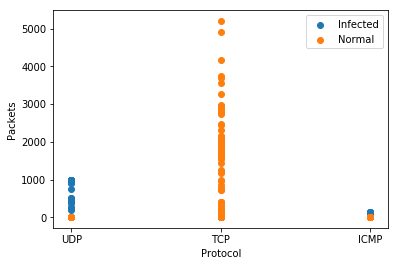

In [17]:
plt.scatter(infected_flow_sample['Protocol'], infected_flow_sample['Packets'],label="Infected")
plt.scatter(normal_flow_sample['Protocol'], normal_flow_sample['Packets'], label="Normal")
plt.legend()
plt.xlabel("Protocol")
plt.ylabel("Packets")

Text(0,0.5,'Bytes')

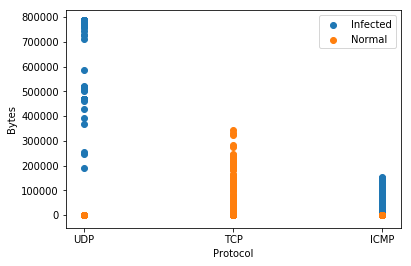

In [18]:
plt.scatter(infected_flow_sample['Protocol'], infected_flow_sample['Bytes'],label="Infected")
plt.scatter(normal_flow_sample['Protocol'], normal_flow_sample['Bytes'], label="Normal")
plt.legend()
plt.xlabel("Protocol")
plt.ylabel("Bytes")

## Discretization

In [19]:
def plot_elbow(samples, feature="Packets", max_k=10):
    datapoints = samples[feature].sort_values()
    sse_list = []
    for k in range(1,max_k+1):
        sse = 0
        _,_,sse = k_means(np.array(datapoints).reshape(-1,1), k)
        sse_list.append(sse)
    plt.figure()
    plt.plot(range(1,len(sse_list)+1), sse_list)
    plt.xlabel("number of clusters")
    plt.ylabel("sum of squared distances")
    plt.title("Cluster Size for " + feature)

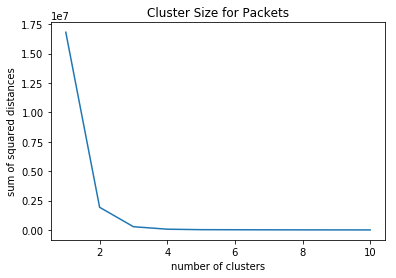

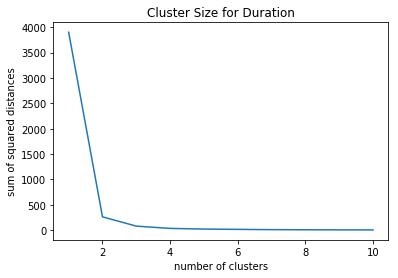

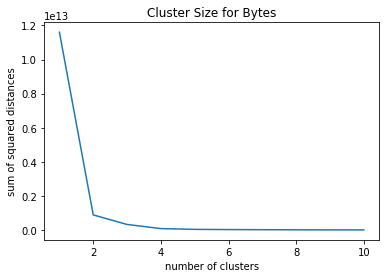

In [20]:
samples = infected_flow_sample.sample(frac=0.1) # use only 10% of data
plot_elbow(samples, "Packets", 10)
plot_elbow(samples, "Duration", 10)
plot_elbow(samples, "Bytes", 10)

We can see that the elbow for all three features (duration, packets, and bytes) are at around cluster=4, so we will use the 25th, 50th, 75th percentile for discretizing these features

In [21]:
# discretize
def discretize(sample, feature, percentile_ranks=[25,50,75]):
    feature_values = sample[feature]
    percentiles = [np.percentile(feature_values,x) for x in percentile_ranks]
    print(percentiles)
    discrete_output = []
    for x in list(feature_values):
        discrete_value = None
        
        for idx,percentile in enumerate(percentiles):
            if x <= percentile and discrete_value is None:
                discrete_value = idx
                break;
                
        if discrete_value is None:
            discrete_value = len(percentiles)
        
        discrete_output.append(discrete_value)
    
    return discrete_output

In [22]:
infected_flow_sample['d_Packets'] = discretize(infected_flow_sample, "Packets")
infected_flow_sample['d_Bytes'] = discretize(infected_flow_sample, "Bytes")
infected_flow_sample['d_Duration'] = discretize(infected_flow_sample, "Duration")

map_protocol = {"TCP": 0, "UDP": 1, "ICMP": 2}
infected_flow_sample['d_Protocol'] = infected_flow_sample['Protocol'].apply(lambda x: map_protocol[x])

[1.0, 1.0, 1.0]
[1066.0, 1066.0, 1066.0]
[0.0, 0.0, 0.0]


In [23]:
infected_flow_sample['d_Packets'] = infected_flow_sample['d_Packets'].astype(CategoricalDtype(range(4)))
infected_flow_sample['d_Bytes'] = infected_flow_sample['d_Bytes'].astype(CategoricalDtype(range(4)))
infected_flow_sample['d_Duration'] = infected_flow_sample['d_Bytes'].astype(CategoricalDtype(range(4)))

In [24]:
len(infected_flow_sample['d_Packets'].cat.categories)

4

## Netflow Encoding
The following algorithm is from the reference "Learning Behavioral Fingerprints From Netflows Using Timed Automata"
1. `code` <- 0
2. `spaceSize` <- product of all number of values for each feature
3. for each feature a we do the following:
   1. `code` <- `code` + `discrete mapping of feature a` * (`spaceSize` / `number of values for feature a`)
   2. `spaceSize` <- `spaceSize`/`number of values for feature a`
4. return `code`

In [25]:
def netflow_encoding(samples, features=['d_Protocol','d_Bytes'], verbose=False):
    code_list = []
    num_unique_values = {}
    
    for feature in features:
        if samples[feature].dtype.name == "Category":
            len(samples[feature].cat.categories)
        else:
            num_unique_values[feature] = samples[feature].nunique()
    
    counter = 0
    for _,item in samples.iterrows():
        counter = counter + 1
        if verbose:
            print ("Processing",counter,"out of", len(samples))
        code = 0
        space_size = np.prod([num_unique_values[feature] for feature in features])
        for feature in features:
            code = code + item[feature] * space_size/num_unique_values[feature]
            space_size = space_size/num_unique_values[feature]
        code_list.append(int(code))
        
    return code_list

In [26]:
infected_flow_sample['event_id'] = netflow_encoding(infected_flow_sample)

In [27]:
infected_flow_sample['event_id'].head()

299473    2
300156    2
300159    3
300735    2
300740    5
Name: event_id, dtype: int64

In [28]:
infected_flow_sample.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label,d_Packets,d_Bytes,d_Duration,d_Protocol,event_id
299473,2011-08-18,2011-08-18 10:37:58.448,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,64,1,Botnet,0,0,0,1,2
300156,2011-08-18,2011-08-18 10:38:00.695,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,87,1,Botnet,0,0,0,1,2
300159,2011-08-18,2011-08-18 10:38:00.706,0.043,TCP,147.32.84.165,->,74.125.232.206,SRPA_,0,4,629,1,Botnet,3,3,3,0,3
300735,2011-08-18,2011-08-18 10:38:03.255,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,76,1,Botnet,0,0,0,1,2
300740,2011-08-18,2011-08-18 10:38:03.267,2.990,UDP,147.32.84.165,->,65.55.56.40,INT,0,2,180,1,Botnet,3,3,3,1,5


## Apply the encoding to the whole dataset

In [29]:
# this might take some time, you can instead skip running the cell and load the file in the next cell
# uncoment if you want to run this cell
# dataset['d_Bytes'] = discretize(dataset, "Bytes")
# dataset['d_Bytes'] = dataset['d_Bytes'].astype(CategoricalDtype(range(4)))

# map_protocol = {"TCP": 0, "UDP": 1, "ICMP": 2}
# dataset['d_Protocol'] = dataset['Protocol'].apply(lambda x: map_protocol[x])

# dataset['event_id'] = netflow_encoding(dataset, verbose=False)
# #save to file
# dataset.to_csv('output/scenario10_discretized.csv')

You need to download the file from here (https://drive.google.com/file/d/1auTSln9VUXbw1PPgC3I5_Kk_zkBUXOA1/view?usp=sharing) and put it in the `output` folder 

In [30]:
# read the file
dataset = pd.read_csv('output/scenario10_discretized.csv',index_col=0)
dataset['Start'] = pd.to_datetime(dataset['Start'])
dataset.sort_values(by='Start',inplace=True)
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label,d_Packets,d_Protocol,event_id,d_Bytes
20,2011-08-18,2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,->,147.32.85.88,PA_,0,91,86277,1,LEGITIMATE,3,0,3,3
51,2011-08-18,2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,->,74.125.232.214,A_,0,1,66,1,LEGITIMATE,0,0,0,0
57,2011-08-18,2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,->,147.32.80.13,A_,0,49,3234,1,LEGITIMATE,3,0,3,3
73,2011-08-18,2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,->,74.125.108.208,A_,0,118,7080,1,LEGITIMATE,3,0,3,3
75,2011-08-18,2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,->,74.125.232.215,A_,0,1,60,1,LEGITIMATE,0,0,0,0


In [33]:
infected_host_ip = infected_hosts[0]
infected_flow_sample = pd.DataFrame(dataset.loc[(dataset['Source_IP'] == infected_host_ip)])

infected_flow_sample.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label,d_Packets,d_Protocol,event_id,d_Bytes
299473,2011-08-18,2011-08-18 10:37:58.448,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,64,1,Botnet,0,1,4,0
300156,2011-08-18,2011-08-18 10:38:00.695,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,87,1,Botnet,0,1,4,0
300159,2011-08-18,2011-08-18 10:38:00.706,0.043,TCP,147.32.84.165,->,74.125.232.206,SRPA_,0,4,629,1,Botnet,2,0,1,1
300735,2011-08-18,2011-08-18 10:38:03.255,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,76,1,Botnet,0,1,4,0
300740,2011-08-18,2011-08-18 10:38:03.267,2.990,UDP,147.32.84.165,->,65.55.56.40,INT,0,2,180,1,Botnet,2,1,4,0


In [ ]:
# create a list of timed events
timed_events = []
prev_timestamp = None
for _,item in infected_flow_sample.iterrows():
    if prev_timestamp is None:
        time_delta = 0
    else:
        time_delta = int((item['Start'] - prev_timestamp).total_seconds() * 1000) # save milliseconds
    # update prev_timestamp for next row
    prev_timestamp = item['Start']
    
    timed_events.append((item['event_id'],time_delta))

In [ ]:
# for all hosts
timed_events = {}
for host_ip in infected_hosts + normal_hosts:
    host_flows = pd.DataFrame(dataset.loc[(dataset['Source_IP'] == host_ip)])
    
    timed_events[host_ip] = []
    
    prev_timestamp = None
    for _,item in host_flows.iterrows():
        if prev_timestamp is None:
            time_delta = 0
        else:
            time_delta = int((item['Start'] - prev_timestamp).total_seconds() * 1000) # save milliseconds
        # update prev_timestamp for next row
        prev_timestamp = item['Start']

        timed_events[host_ip].append((item['event_id'],time_delta))

In [ ]:
# writing this to file for Task 4
import json
 
json = json.dumps(timed_events)
f = open("output/events_scenario10.json","w")
f.write(json)
f.close()

In [ ]:
timed_events["147.32.84.165"]

In [ ]:
infected_flow_sample.head()